<a href="https://colab.research.google.com/github/rmandalam/CPROJECT/blob/master/HW1_MANDALAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q1: After your yearly checkup, the doctor has bad news and good news. The bad news is that you tested positive for a serious disease, and that the test is
    99% accurate (i.e., the probability of testing positive given that you have the disease is 0.99, as is the probability of testing negative given that
    you don’t have the disease). The good news is that this is a rare disease, striking only one in 10,000 people. What are the chances that you actually
    have the disease? (Show your calculations as well as giving the final result.)

Answer:

1) What is Known:
- Probability of Having the Disease: 1/10,000 = 0.0001
- Probability of Testing Positive: 0.99 -> Out of 10,000 people, 9,999 will be positive & 1 will be negative
- Probability of Testing Negative: 0.99 -> Out of 10,000 people, 9,999 will be negative & 1 will be positive
- Accuracy of the Test: 0.99
- False Positive Rate of the Test: 0.01 -> Meaning out of 10,000 people, 100 will have a false positive

2) What is Unknown:
- Probability of Having the Disease Given Postiive Test

3) Formula to Use:
- Bayes Theorem -> P(A|B) = P(B|A) * P(A) / P(B)
- A = Disease
- B = Positive
- A2 = No Disease
- B2 = Negative

4) Calculation:
- P(B|A) = 0.99 -> Tested positive given that you have the disease
- P(A) = 1/10,000 = 0.0001 -> Have the disease
- P(B) = 0.99 -> (0.99 * 0.0001) + (0.01 * 0.9999) = 0.010098 -> Tested Positive -> The (0.01 * 0.9999) accounts for tests that are False Positives
- P(A|B) = (0.99 * 0.0001) / 0.010098 = 0.009801 = 98%

- Answer: Approximately 98% chance that you actually have the disease


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbrn

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

#I) Loading the Data into the Code:

#1) Read the dataset file (KaggleV2-May-2016.csv)
def load_dataset():
    dataset = pd.read_csv('KaggleV2-May-2016.csv')
    return dataset

#2) Validate that the code successfully loaded the dataset by examining the contents in the console
appointment_data = load_dataset()

#Quickly view the first 5 rows of the dataset
appointment_data.head()
'''This will show us the general overview of the dataset, but we will want to dig deeper into the data types & identify any
missing values in the dataset'''

#View the data types of the available features in the dataset
appointment_data.info()
'''After running this, we will see that there are 5 categorical features with an 'object' data type (Gender, ScheduledDay, AppointmentDay, Neighbourhood,
& No-show). This means that if we were to select any one of these features in our model training, then we will need to pre-process these categorical
features into numeric ones.'''

'''We also see that there are 110,527 rows of data in this dataset, which makes this a fairly large one to train a model for. I will be splitting the
data into an 80-20 train/test split later on in the code, which will be used to assess the model's performance'''

#View the columns of the features available in the dataset & store in a variable as reference for pre-processing
features = appointment_data.columns.values
print(features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
['PatientId' 'AppointmentID' 'Gender' 'ScheduledDay' 'AppointmentDay'
 'Age' 'Neighbourhoo

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64
Neighborhood
JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: count, Length: 81, dtype: int64
Number of categories in the Neighborhood column: 81


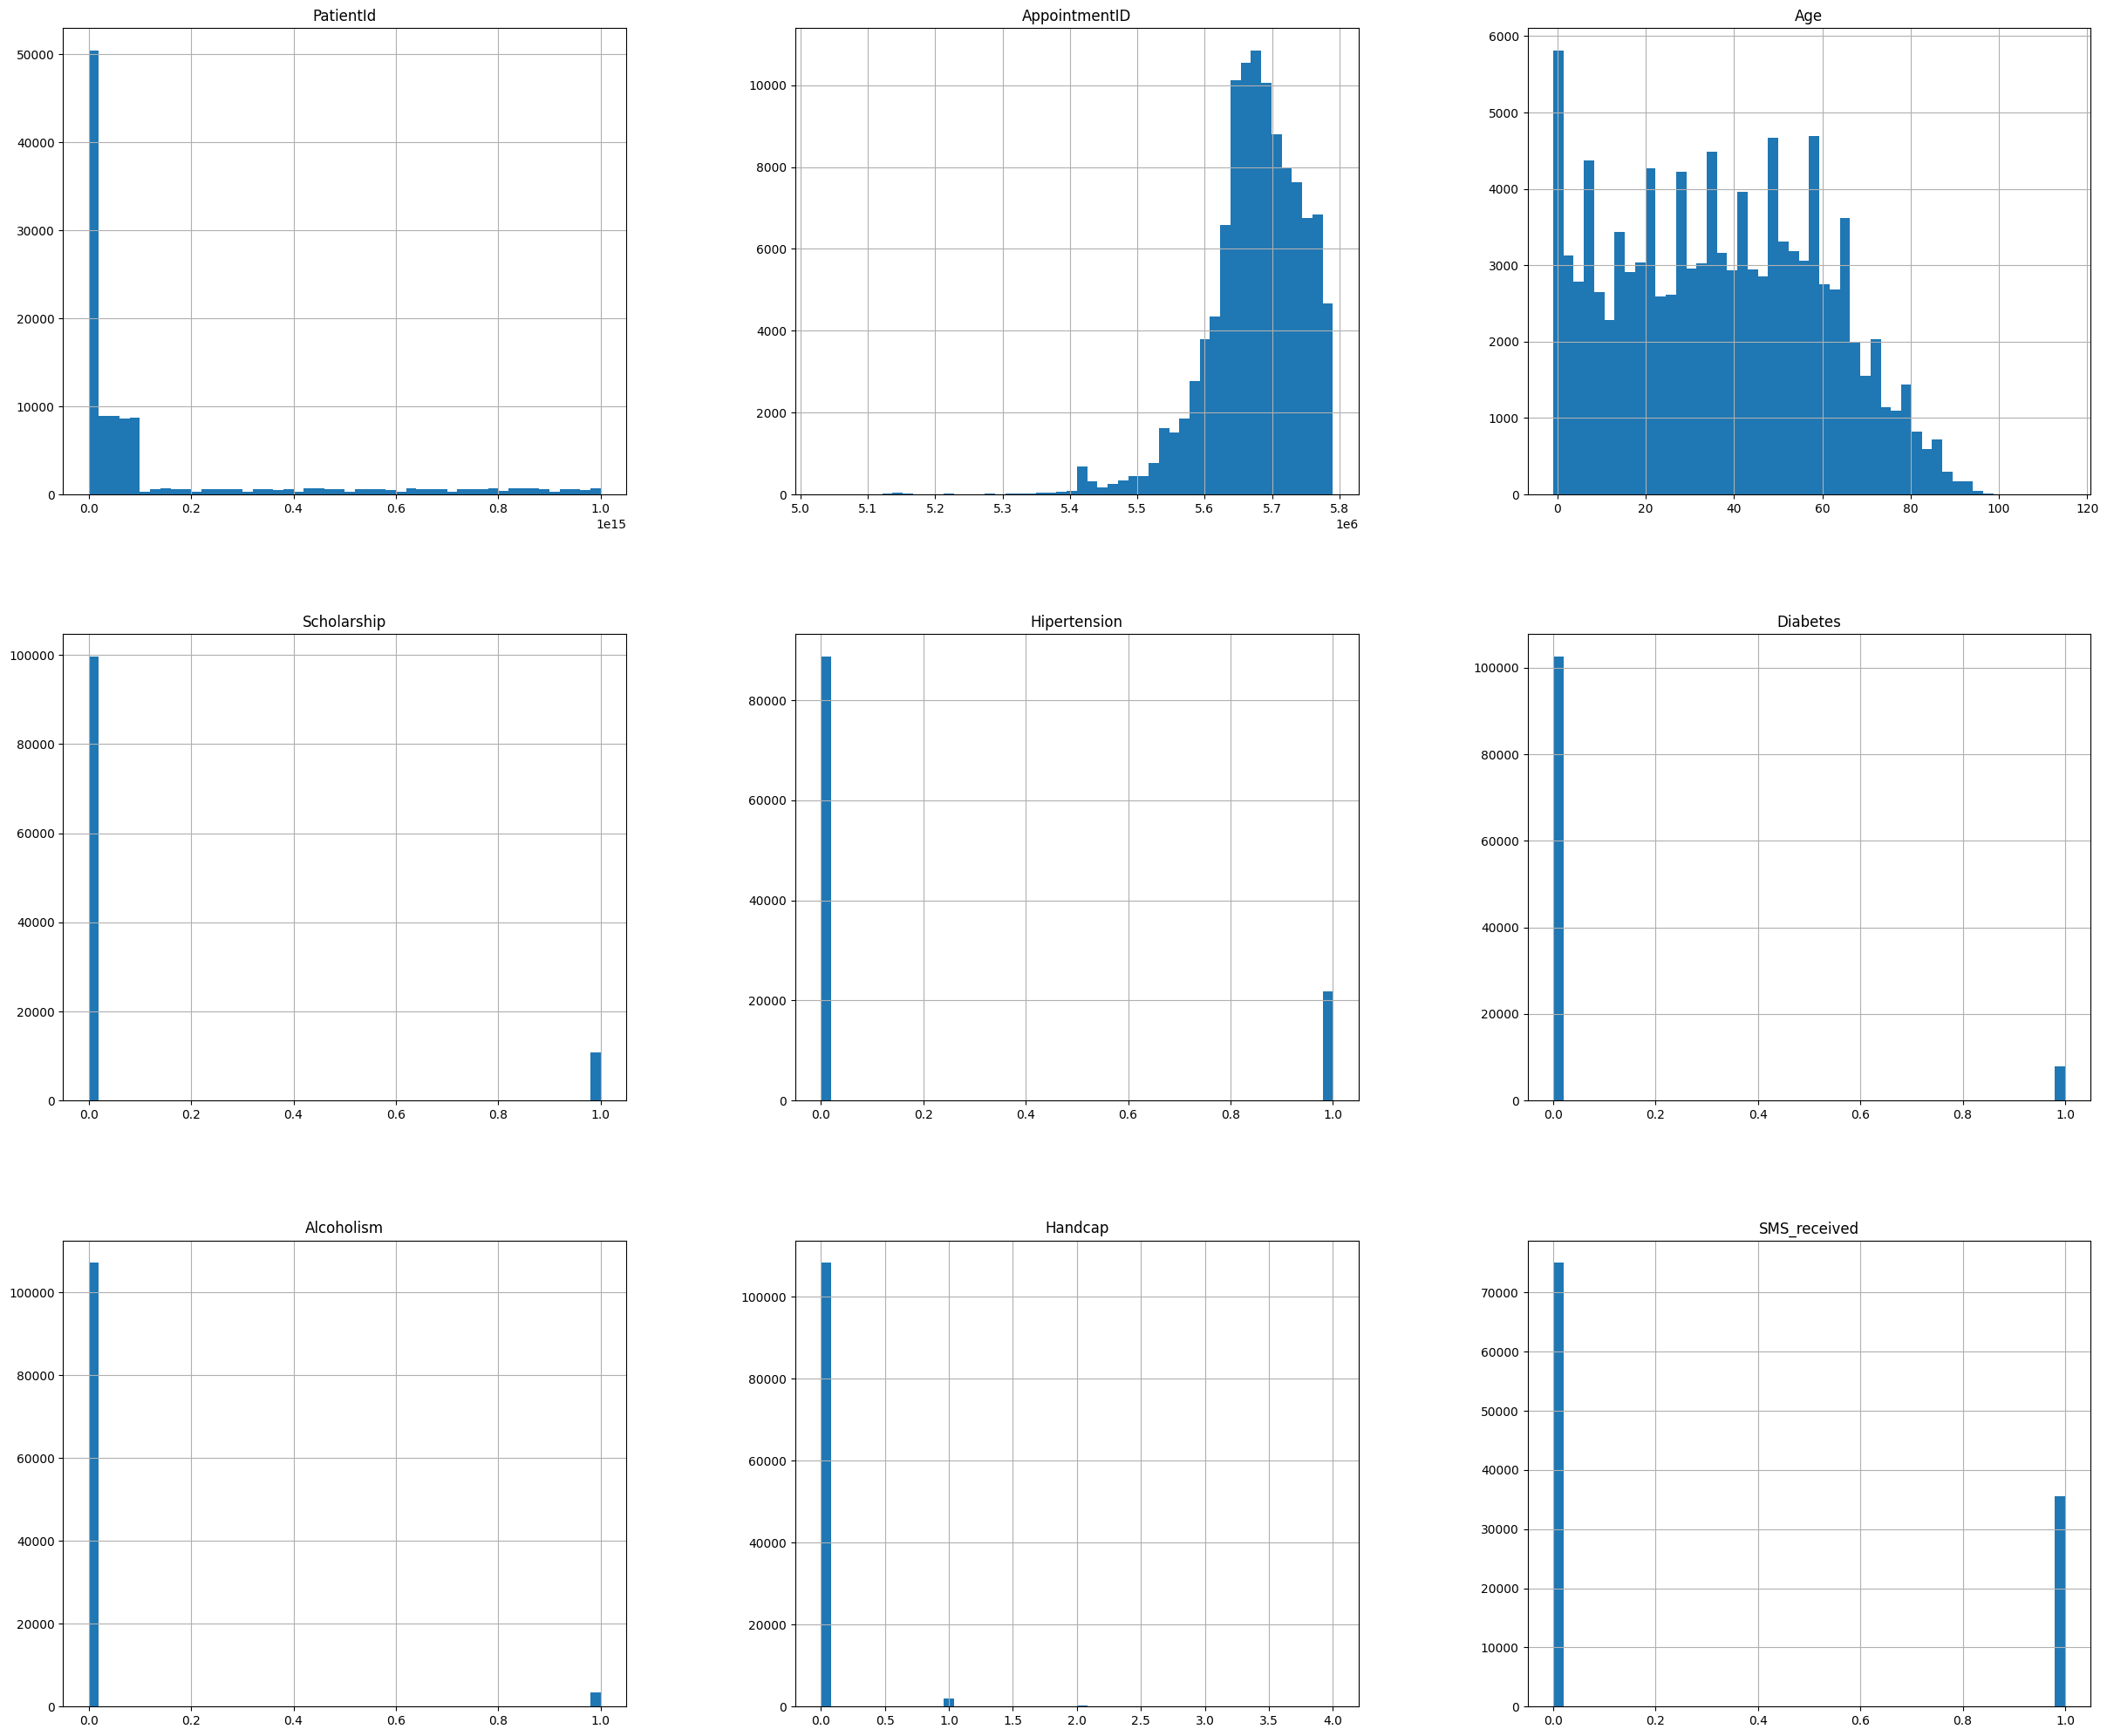

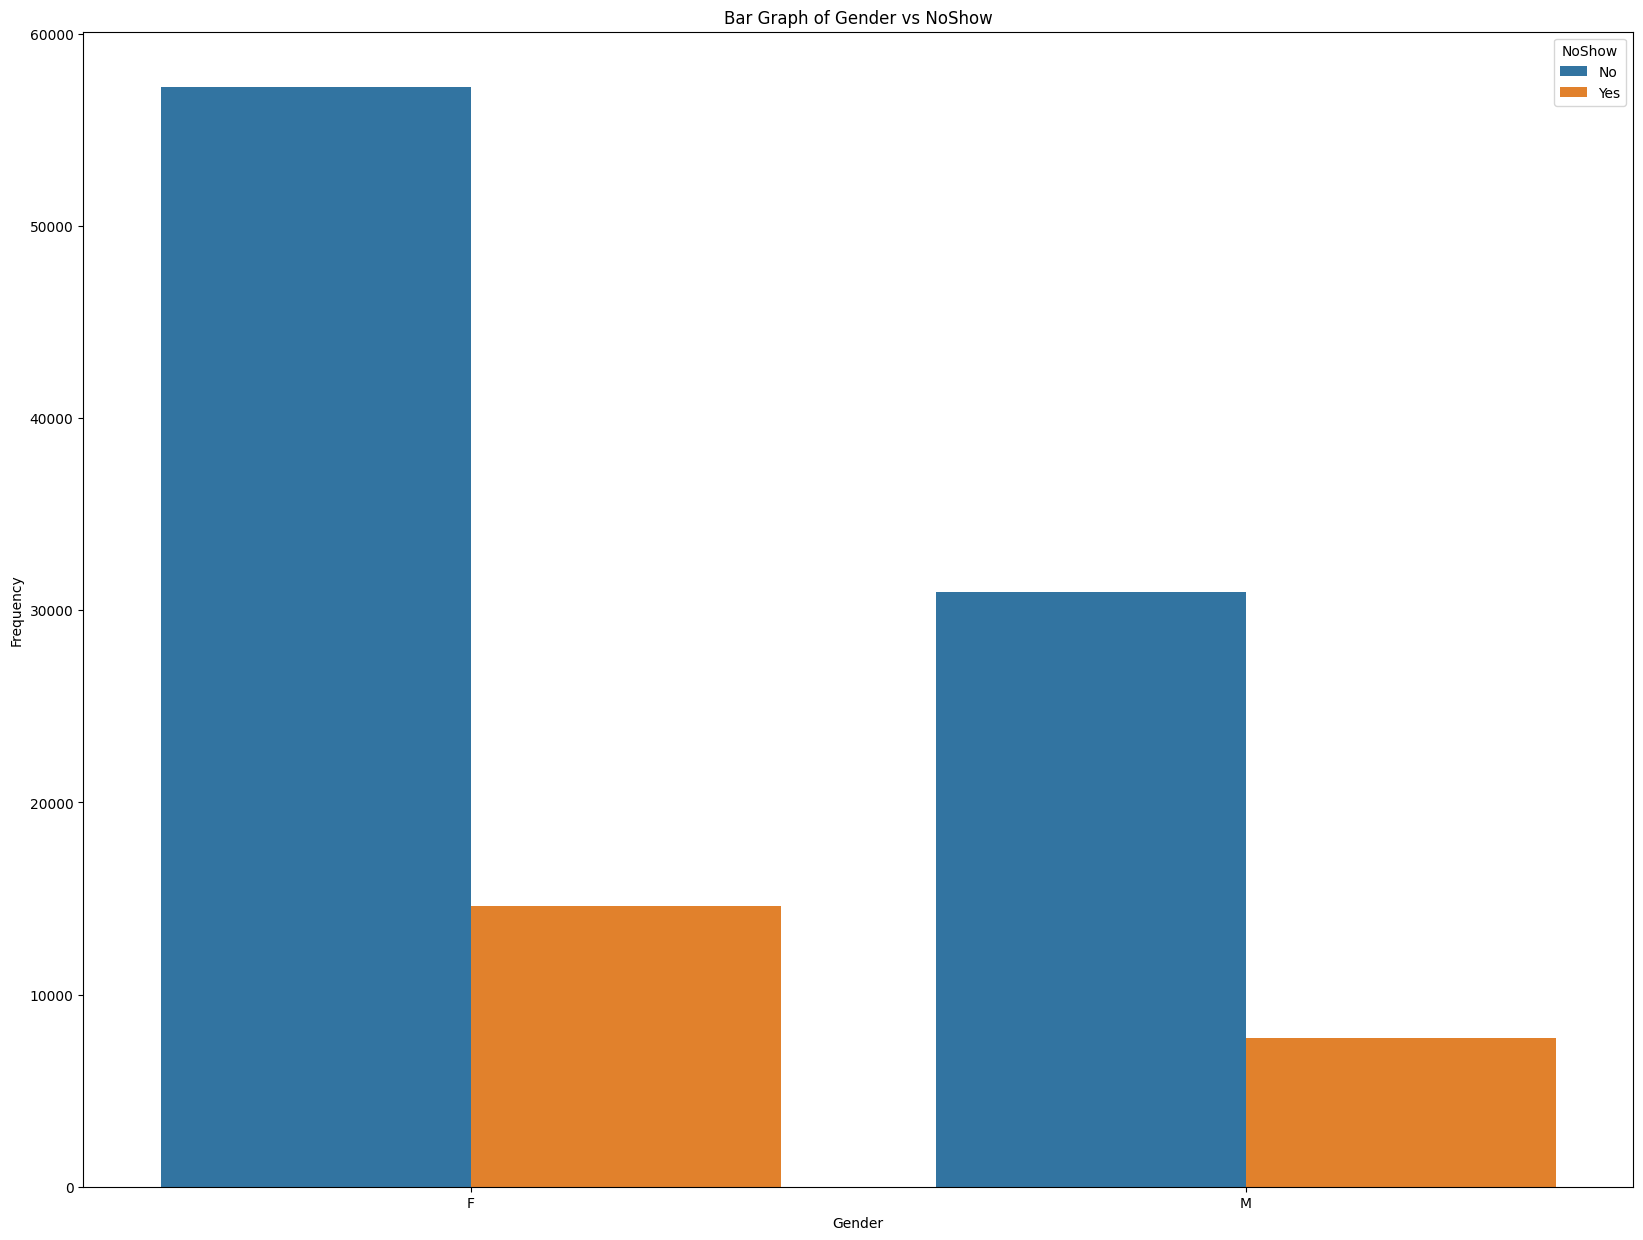

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


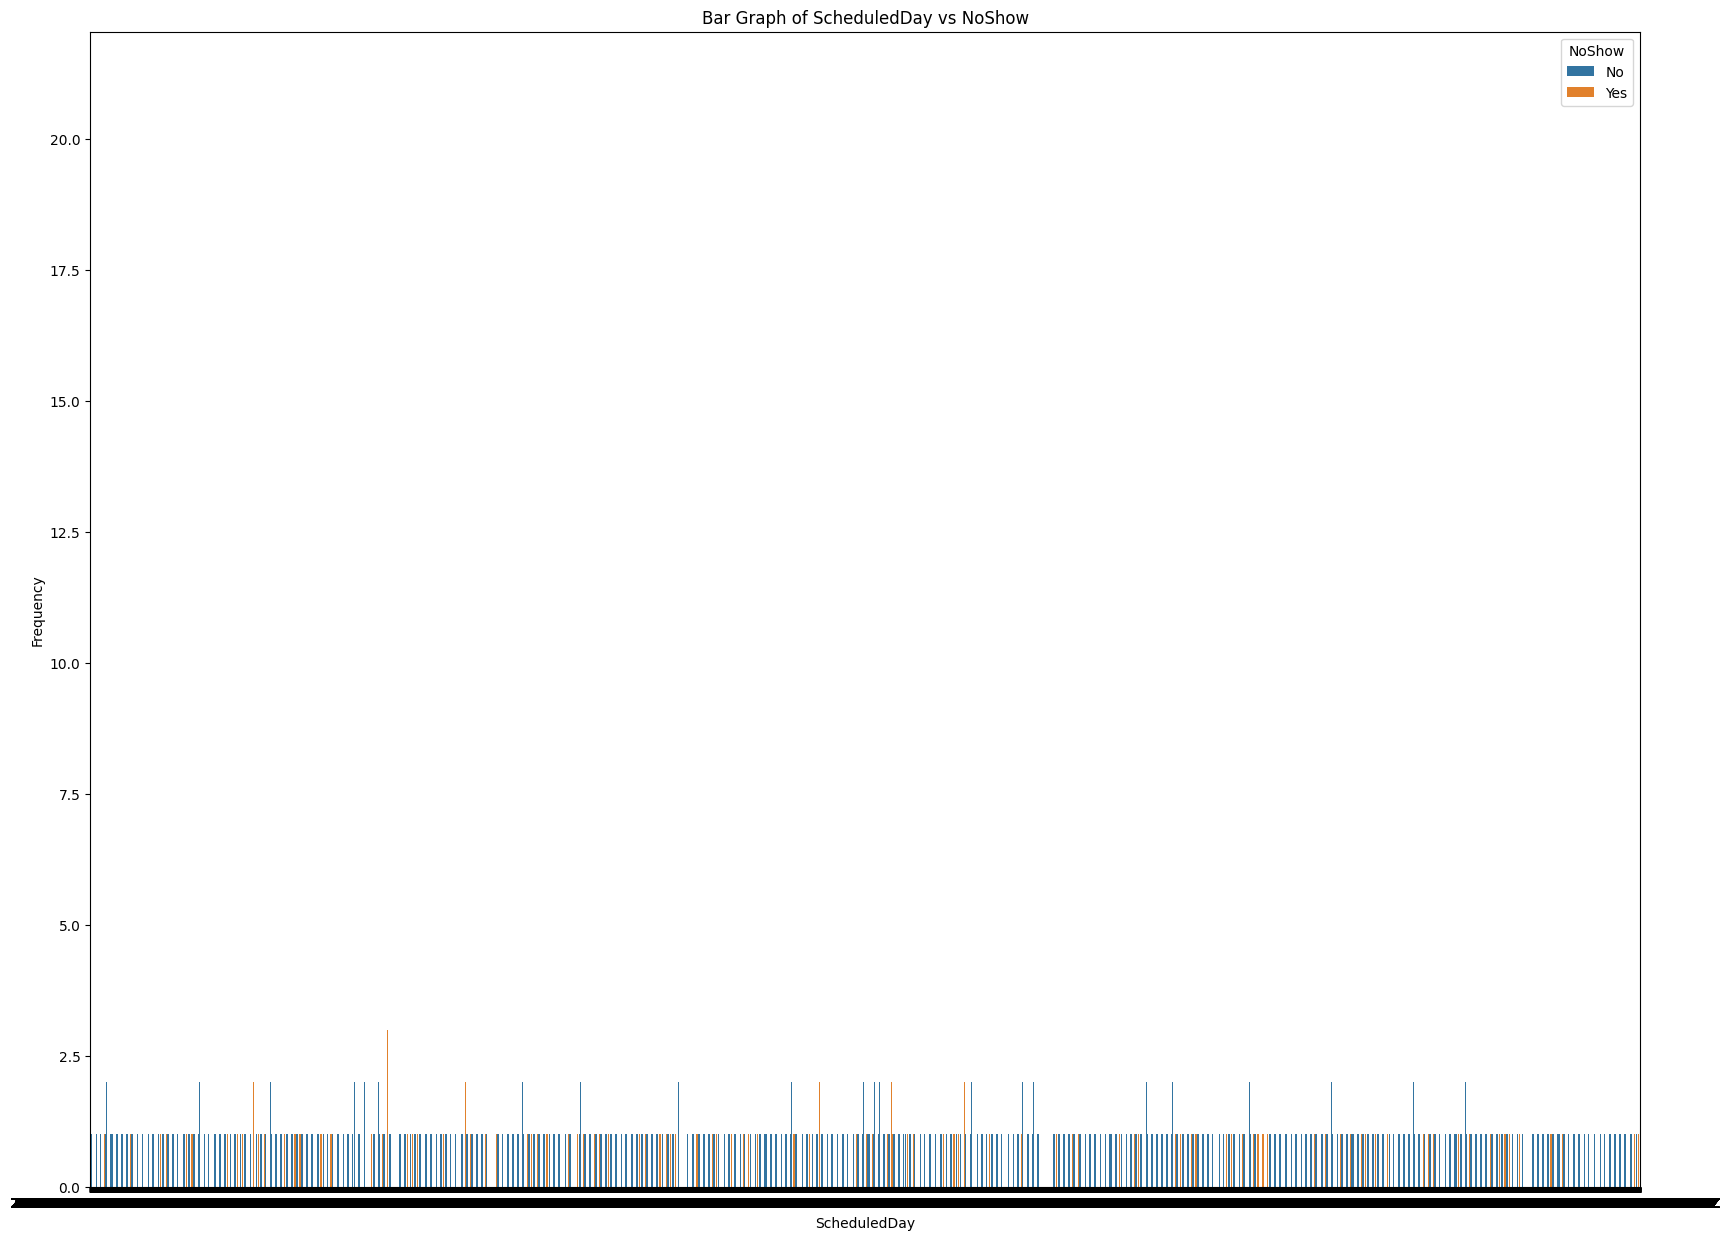

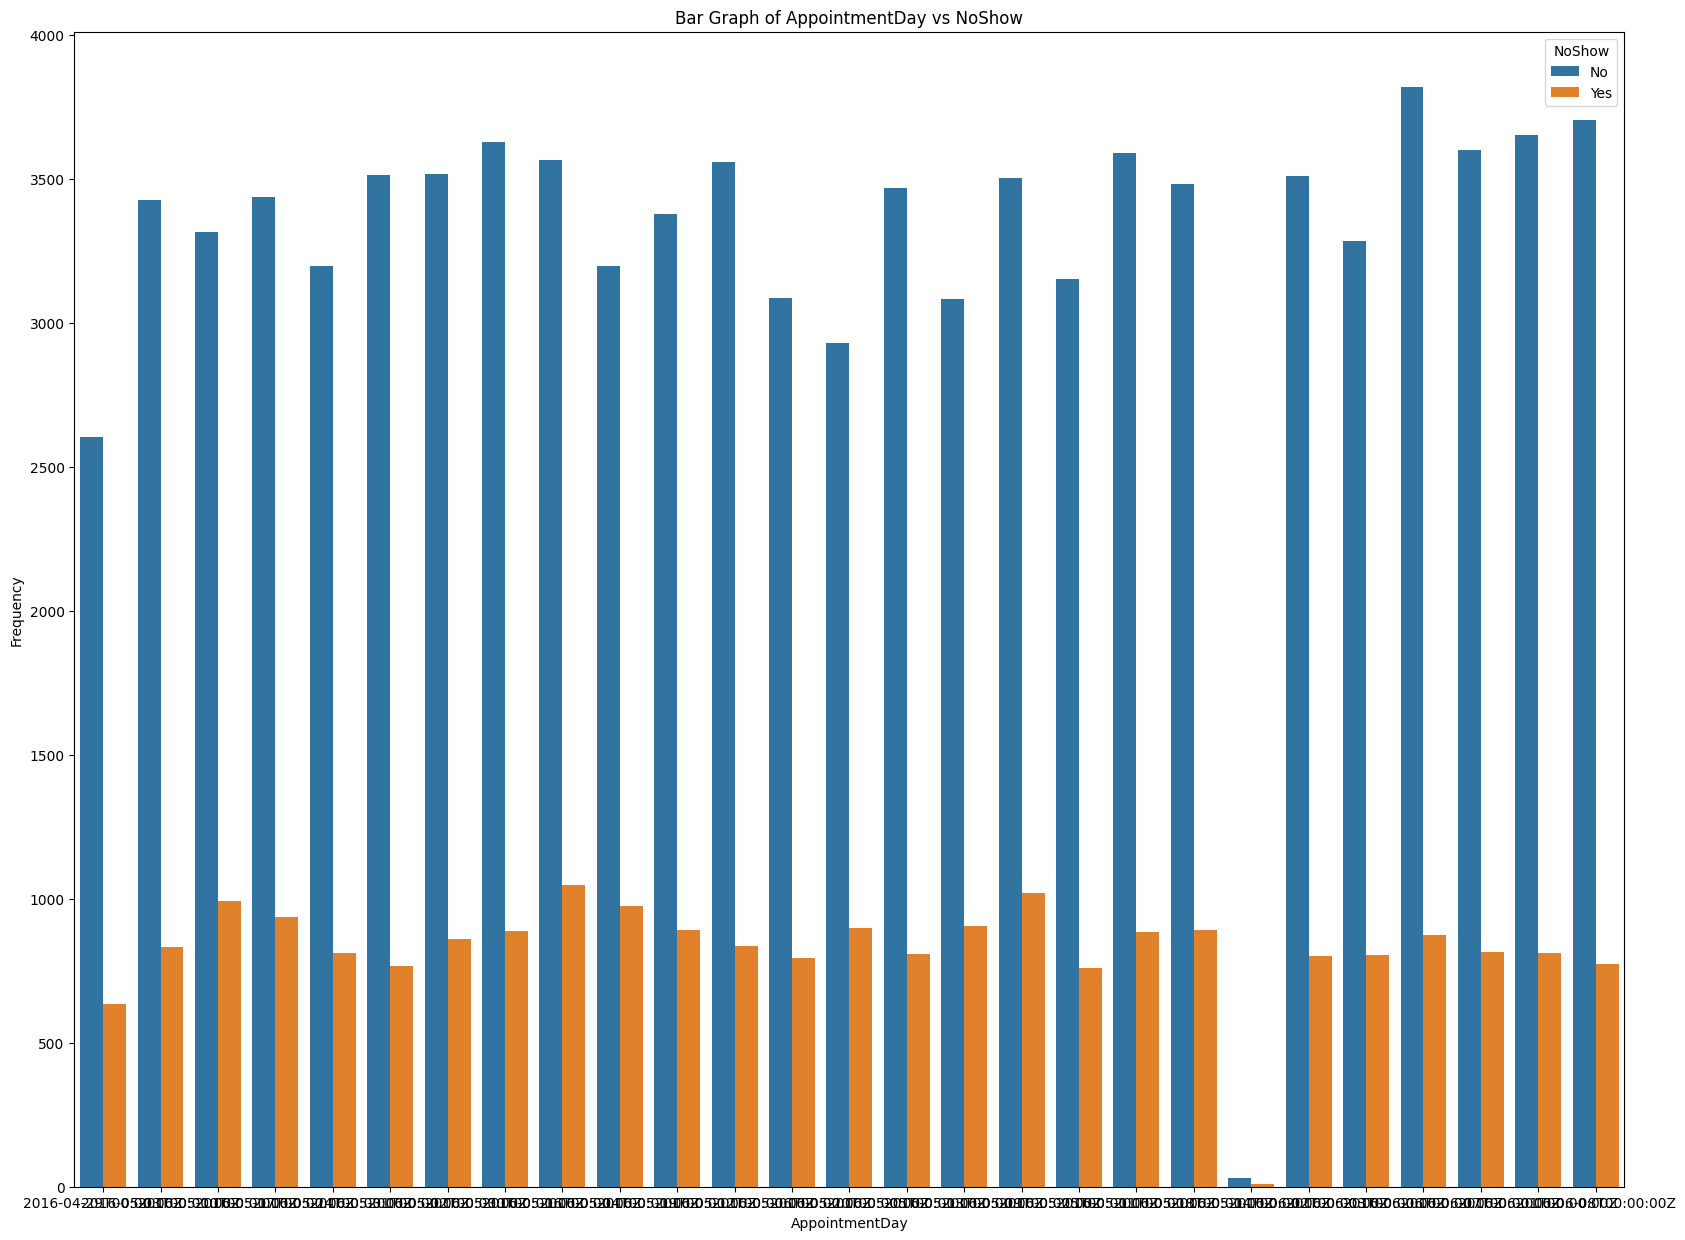

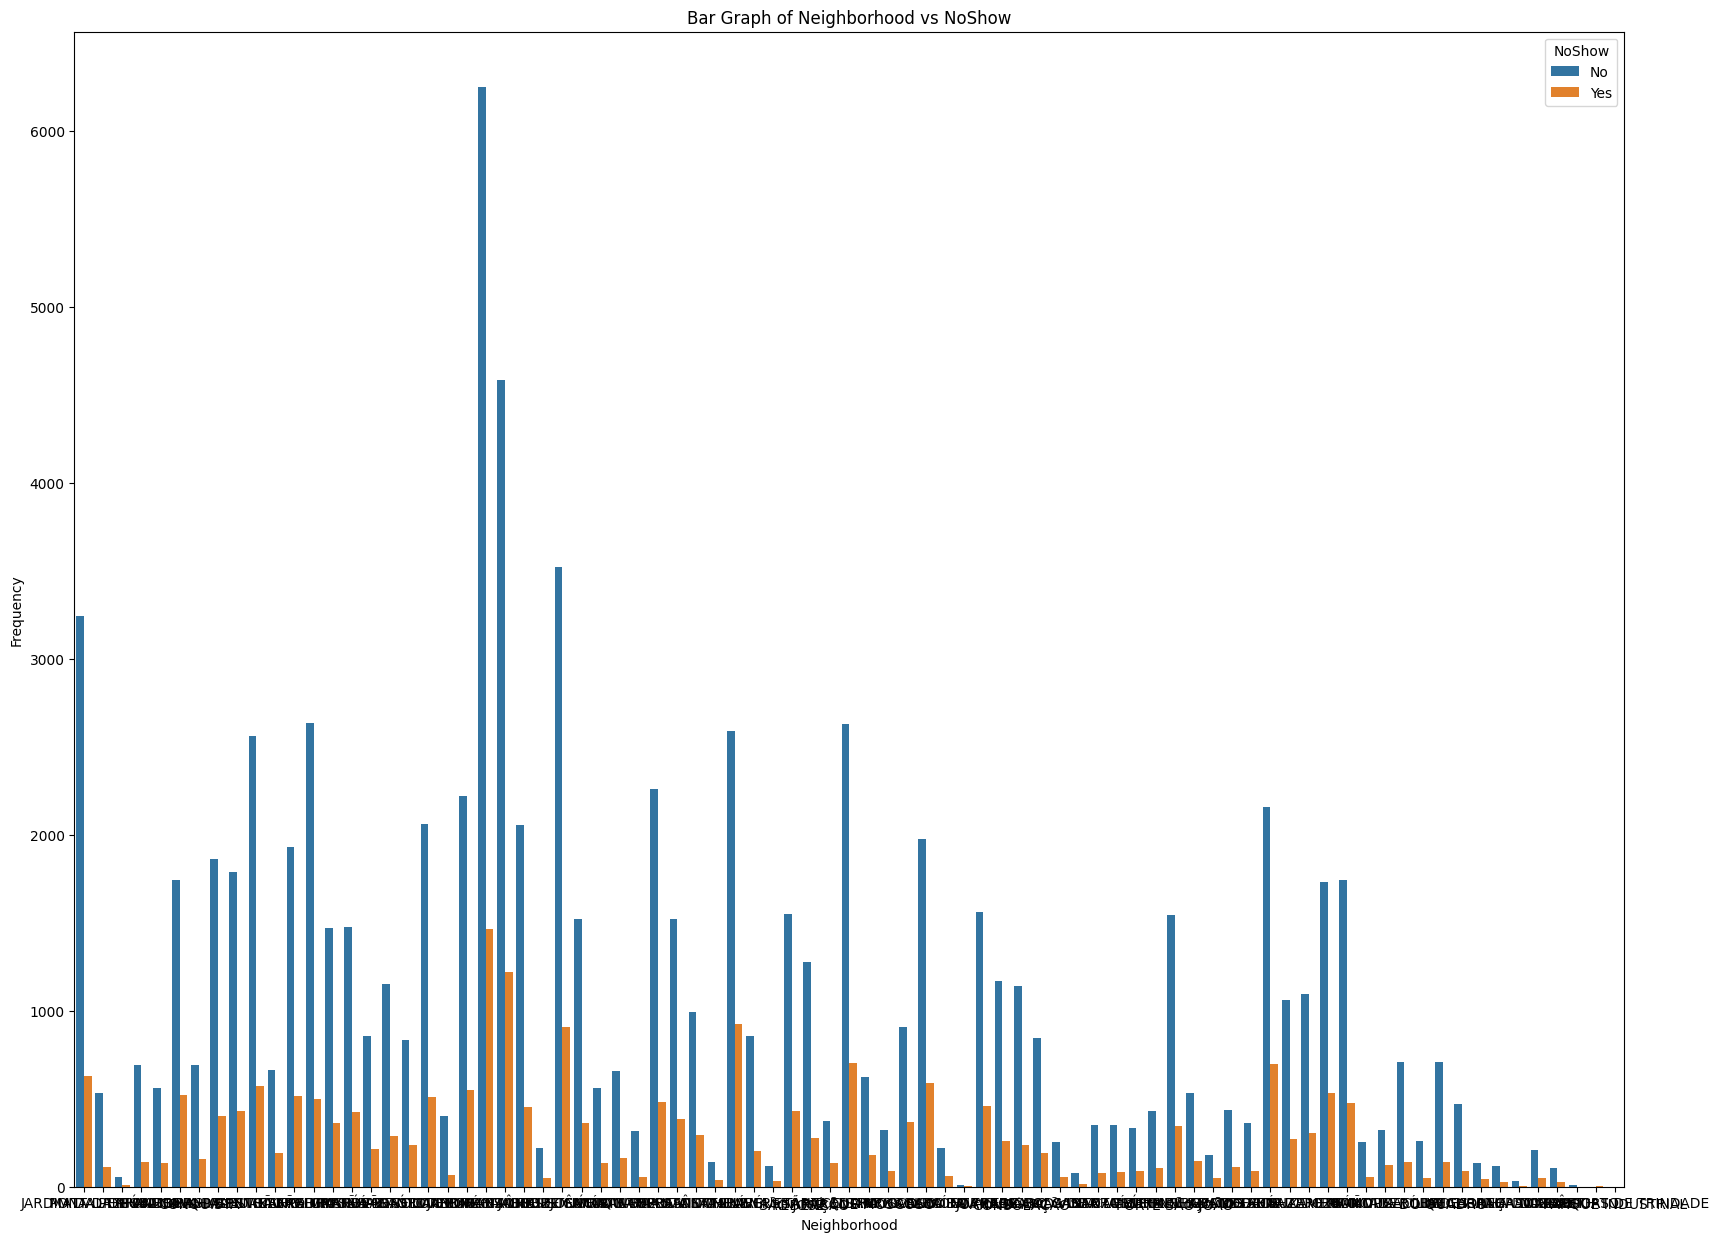

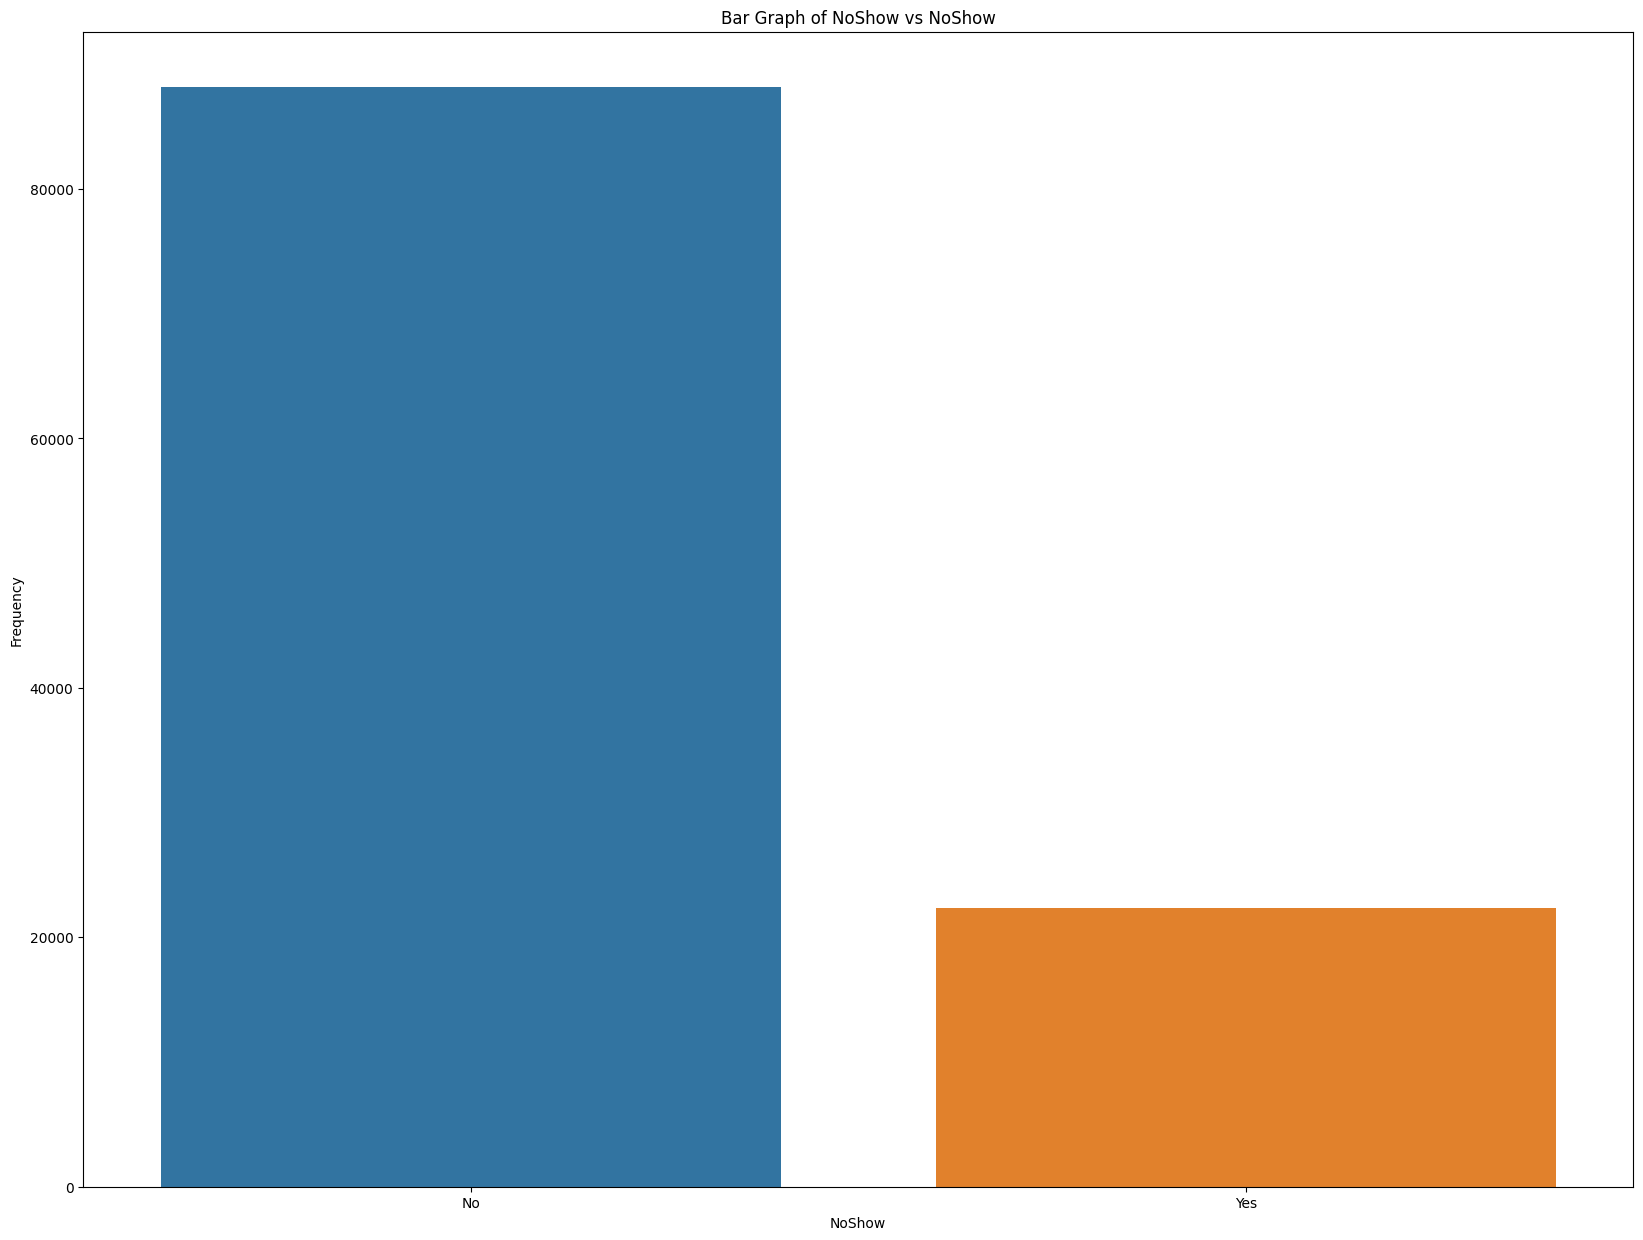

'This bar graph shows the distribution of the categorical features in the dataset. The most important takeaway from this is that the NoShow feature is \nheavily skewed towards the No category, which is consistent with the histogram of the numerical features. This means that the model will have to be trained \non a highly-imbalanced dataset, which will require some additional pre-processing to balance out the data.'

In [2]:
#II) Exploratory Data Analysis:

'''Now that the data has been loaded, the next step is to now understand the dataset that will be used for training. In this part of the program, I
will be identifying any missing values in the dataset, showing the distribution of the features to visualize & identify any correlations with the data,
and then creating a Pipeline to perform my pre-processing techniques & finalize the features selected for training the model on.'''

#1) Identify any missing values in the dataset
missing_values = appointment_data.isnull().sum()
print(missing_values)
'''We can see that there are 0 missing values present in the dataset. This is very rare, especially given how large this dataset is, but it means that
there is no need to do additional handling of missing values using sklearn's SimpleImputer() class. We are fortunate enough to now move on to the next step.'''

#2) Breakdown the categories that exist for the categorical features
appointment_data.rename(columns={
    'Neighbourhood': 'Neighborhood',
    'SMS_received': 'SMS',
    'Handcap': 'Handicap',
    'No-show': 'NoShow'}, inplace=True)
'''I wanted to first rename some of the columns to avoid any future errors where the formatting or spelling of the features was incorrect.'''

neighborhood_categories = appointment_data["Neighborhood"].value_counts()
print(neighborhood_categories)
print("Number of categories in the Neighborhood column:", appointment_data["Neighborhood"].nunique())
'''What this shows me is that there are 81 categories of data within the Neighborhood column, with the largest being 7717 patients located in
the JARDIM CAMBURI neighborhood. This information will help later on when we use the Neighborhood feature as one of the selected features we
use to train our models with, and will provide us with context as to why the model performs the way it does on the data.'''

#3) Plotting a histogram to identify the distribution of numerical variables (AKA: features), and analyze correlations between the data
%matplotlib inline
appointment_data.hist(bins=50, figsize=(30,25))
plt.show()
'''To get a better understanding of the dataset that is being worked with, the easiest method is to leverage matplotlib's graphing capabilities
and chart a histogram of all the numerical features present. The 5 categorical features will also be graphed as well, but they first need to be
transformed during pre-processing before a graph can be developed.'''

'''The biggest takeaway from the numerical feature histograms is that all of the Yes/No numerical features are heavily skewed towards the value 0,
which indicates No. This means that for columns such as SMS, the majority of the patients are not receiving the SMS reminders for their appointment
which indicates a strong correlation with NoShow. We will have to do some pre-processing to balance out these features in which No is the majority.'''

'''Another important takeaway with the Age feature is that the highest value of patients fall at or near 0. This is another problem that will need
to be addressed during pre-processing, as it is illogical to have NoShow for infants and toddlers who are dependent on their parents to attend the
appointment.'''

#4) Plotting a bar graph to identify the distribution of categorical variables
categorical_features = appointment_data.select_dtypes(include=['object']).columns
for categories in categorical_features:
    plt.figure(figsize=(20, 15))
    sbrn.countplot(data=appointment_data, x=categories, hue='NoShow')
    plt.title(f"Bar Graph of {categories} vs NoShow")
    plt.xlabel(categories)
    plt.ylabel("Frequency")
    plt.show()
'''This bar graph shows the distribution of the categorical features in the dataset. The most important takeaway from this is that the NoShow feature is
heavily skewed towards the No category, which is consistent with the histogram of the numerical features. This means that the model will have to be trained
on a highly-imbalanced dataset, which will require some additional pre-processing to balance out the data.'''

In [13]:
#2) Breakdown the categories that exist for the categorical features
appointment_data.rename(columns={
    'Neighbourhood': 'Neighborhood',
    'SMS_received': 'SMS',
    'Handcap': 'Handicap',
    'No-show': 'NoShow'}, inplace=True)

print(appointment_data.columns)
'''I wanted to first rename some of the columns to avoid any future errors where the formatting or spelling of the features was incorrect.'''

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighborhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS', 'NoShow',
       'ScheduledDayOfWeek', 'ScheduledHour', 'AppointmentDayOfWeek',
       'DaysBetween'],
      dtype='object')


'I wanted to first rename some of the columns to avoid any future errors where the formatting or spelling of the features was incorrect.'

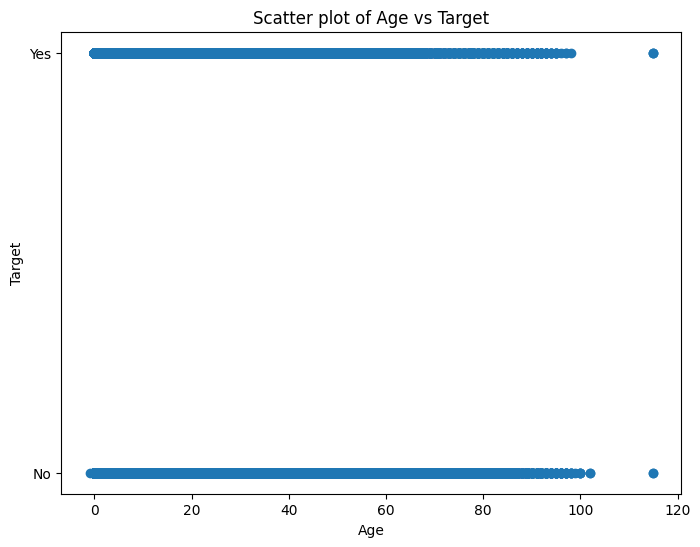

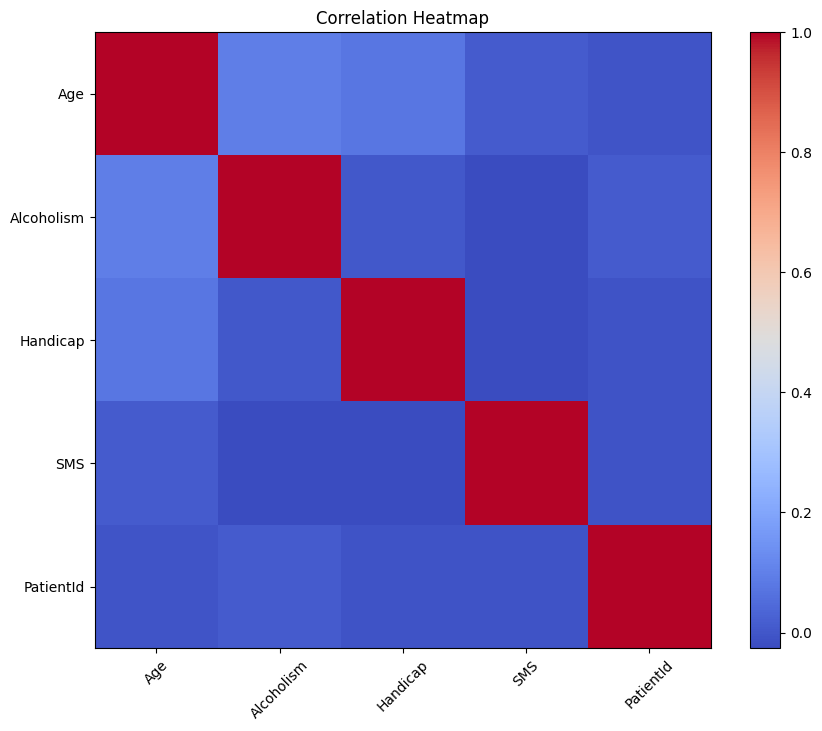

In [16]:
#5) Plotting a scatterplot to identify the correlation between Age and the Target (NoShow)
numerical_features = appointment_data["Age"]
target_variable = appointment_data["NoShow"]

#Plotting the scatter plot
%matplotlib inline
plt.figure(figsize=(8, 6))
plt.scatter(x=numerical_features, y=target_variable)
plt.xlabel("Age")
plt.ylabel("Target")
plt.title("Scatter plot of Age vs Target")
plt.show()
'''With this scatterplot, we can see that there is a strong correlation between Age and NoShow, as the majority of the patients who did not show up for
their appointment were between the ages of 0-10. This is consistent with the histogram of the Age feature, and will be important to keep in mind when
training the model.'''

#6) Using Seaborn to plot a correlation matrix heatmat that will help us identify the dependent and independent variable for Logistic Regression
correlation_matrix = appointment_data[['Age', 'Alcoholism', 'Handicap', 'SMS', 'PatientId']].corr()
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Correlation Heatmap')
plt.show()

In [21]:
#III) Pre-Processing the Data for Training

#1) Selecting the features (predictors) used for training & analyzing the relationship between the predictors and the target (NoShow)
predictors = ["Age", "Neighborhood", "ScheduledDay", "SMS", "PatientId"]
'''The features I selected for training the model are: Age, Neighborhood, ScheduledDay, SMS, and PatientId. The target feature is NoShow.'''

#2) Using One-Hot Encoding to convert categorical features into numeric 0 and 1
cat_encoder = OneHotEncoder()
cat_encoder.fit(appointment_data[["Neighborhood"]])
print(cat_encoder.categories_)
'''This will show us the categories that exist within the Neighborhood feature, and will help us with the next step of encoding the categorical features
into numeric ones.'''

#3) Using Label Encoding to convert the target feature NoShow into numeric 0 and 1
label_encoder = LabelEncoder()
label_encoder.fit(appointment_data["NoShow"])
print(label_encoder.classes_)
'''This will show us the categories that exist within the NoShow feature, and will help us with the next step of encoding the target feature into numeric
ones.'''

#4) Normalizing the SchedluedDay feature to a 0-1 scale
# Convert the columns to datetime
appointment_data['ScheduledDay'] = pd.to_datetime(appointment_data['ScheduledDay'])
appointment_data['AppointmentDay'] = pd.to_datetime(appointment_data['AppointmentDay'])

#Extract useful features
appointment_data['ScheduledDayOfWeek'] = appointment_data['ScheduledDay'].dt.dayofweek
appointment_data['ScheduledHour'] = appointment_data['ScheduledDay'].dt.hour
appointment_data['AppointmentDayOfWeek'] = appointment_data['AppointmentDay'].dt.dayofweek
appointment_data['DaysBetween'] = (appointment_data['AppointmentDay'] - appointment_data['ScheduledDay']).dt.days
'''This will show us the minimum and maximum values of the ScheduledDay feature, which will help us with the next step of normalizing the feature into a 0-1 scale.'''

appointment_data['ScheduledDay'] = appointment_data['ScheduledDay'].astype(np.int64) // 10**9
#This line converts the ScheduledDay column to numerical values representing Unix timestamps (seconds since the epoch).
#It first converts the datetime objects to int64, representing nanoseconds since the epoch, and then divides by 10^9 to get seconds.

#5) Creating a Pipeline to pre-process the data
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()), #This pipeline will standardize the numerical features in the dataset, which is important for training the model.
])

num_attribs = list(numerical_features)  #This will store the numerical features in a variable for reference.'''
cat_attribs = ["Neighborhood"]  #This will store the categorical features in a variable for reference.'''

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
'''This will create a full pipeline that will pre-process the data by standardizing the numerical features and encoding the categorical features into numeric ones.'''

[array(['AEROPORTO', 'ANDORINHAS', 'ANTÔNIO HONÓRIO',
       'ARIOVALDO FAVALESSA', 'BARRO VERMELHO', 'BELA VISTA',
       'BENTO FERREIRA', 'BOA VISTA', 'BONFIM', 'CARATOÍRA', 'CENTRO',
       'COMDUSA', 'CONQUISTA', 'CONSOLAÇÃO', 'CRUZAMENTO', 'DA PENHA',
       'DE LOURDES', 'DO CABRAL', 'DO MOSCOSO', 'DO QUADRO',
       'ENSEADA DO SUÁ', 'ESTRELINHA', 'FONTE GRANDE', 'FORTE SÃO JOÃO',
       'FRADINHOS', 'GOIABEIRAS', 'GRANDE VITÓRIA', 'GURIGICA', 'HORTO',
       'ILHA DAS CAIEIRAS', 'ILHA DE SANTA MARIA', 'ILHA DO BOI',
       'ILHA DO FRADE', 'ILHA DO PRÍNCIPE', 'ILHAS OCEÂNICAS DE TRINDADE',
       'INHANGUETÁ', 'ITARARÉ', 'JABOUR', 'JARDIM CAMBURI',
       'JARDIM DA PENHA', 'JESUS DE NAZARETH', 'JOANA D´ARC',
       'JUCUTUQUARA', 'MARIA ORTIZ', 'MARUÍPE', 'MATA DA PRAIA',
       'MONTE BELO', 'MORADA DE CAMBURI', 'MÁRIO CYPRESTE', 'NAZARETH',
       'NOVA PALESTINA', 'PARQUE INDUSTRIAL', 'PARQUE MOSCOSO', 'PIEDADE',
       'PONTAL DE CAMBURI', 'PRAIA DO CANTO', 'PRAIA DO SUÁ'

'This will create a full pipeline that will pre-process the data by standardizing the numerical features and encoding the categorical features into numeric ones.'

In [22]:
#IV) Split the Data into Train-Test

#1) Splitting into 80-20 using train_test_split
X = appointment_data[predictors]
X_train, X_test, y_train, y_test = train_test_split(X, appointment_data["NoShow"], test_size=0.2, random_state=42)

#2) Create dummies to represent the train and test data
x = pd.get_dummies(X_train)
x_test = pd.get_dummies(X_test)
y = y_train

Cross-validation scores: [0.79769309 0.79778331 0.79778331 0.79778331 0.79778331 0.79778331
 0.79778331 0.79778331 0.79778331 0.79767021]
Mean cross-validation score: 0.7977629756492809


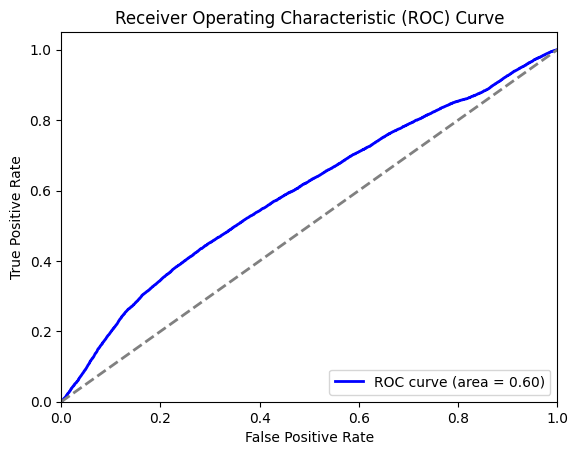

Precision:  0.0
Recall:  0.0
F1-Score:  0.0
AUC:  0.595324594658232
Accuracy:  0.7977629748589136


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
#V) Fit 1: Logistic Regression

#1) Fit the training data for Logistic Regression
y_numeric = y.map({'No': 0, 'Yes': 1})  # Map 'No' to 0 and 'Yes' to 1
logistic_regression = LogisticRegression()
logistic_regression.fit(x, y_numeric)

#2) 10-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(logistic_regression, x, y_numeric, cv=cv)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

#3) Plot the ROC Curve
y_prob = logistic_regression.predict_proba(x)[:, 1]
fpr, tpr, _ = roc_curve(y_numeric, y_prob)
auc = roc_auc_score(y_numeric, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#4) Print out the performance metrics
y_pred = logistic_regression.predict(x)
print("Precision: ", precision_score(y_numeric, y_pred))
print("Recall: ", recall_score(y_numeric, y_pred))
print("F1-Score: ", f1_score(y_numeric, y_pred))
print("AUC: ", roc_auc_score(y_numeric, y_prob))
print("Accuracy: ", accuracy_score(y_numeric, y_pred))

Cross-validation scores: [0.79780617 0.79755711 0.79755711 0.7981226  0.79823569 0.7981226
 0.7980095  0.7978964  0.7980095  0.7978964 ]
Mean cross-validation score: 0.7979213095886182


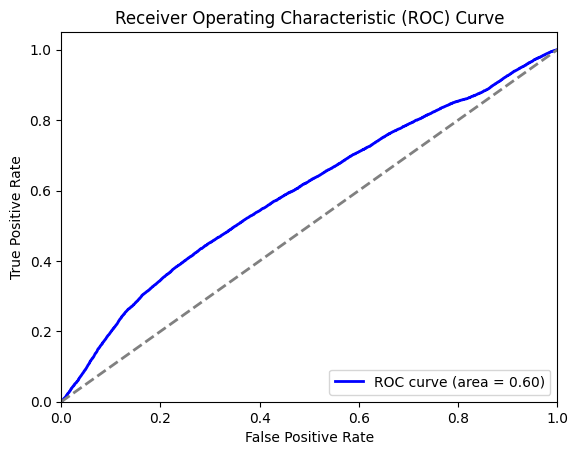

Precision:  0.0
Recall:  0.0
F1-Score:  0.0
AUC:  0.595324594658232
Accuracy:  0.7977629748589136


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
#VI) Fit 2: Decision Tree

#1) Fit the training data for Decision Tree
decision_tree = DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x, y_numeric)

#2) 10-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(decision_tree, x, y_numeric, cv=cv)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

#3) Plot the ROC Curve
y_prob = logistic_regression.predict_proba(x)[:, 1]
fpr, tpr, _ = roc_curve(y_numeric, y_prob)
auc = roc_auc_score(y_numeric, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#4) Print out the performance metrics
y_pred = logistic_regression.predict(x)
print("Precision: ", precision_score(y_numeric, y_pred))
print("Recall: ", recall_score(y_numeric, y_pred))
print("F1-Score: ", f1_score(y_numeric, y_pred))
print("AUC: ", roc_auc_score(y_numeric, y_prob))
print("Accuracy: ", accuracy_score(y_numeric, y_pred))

Cross-validation scores: [0.79147348 0.79111061 0.79043203 0.78658675 0.78975345 0.78737842
 0.79020584 0.79325944 0.78997964 0.79111061]
Mean cross-validation score: 0.7901290265383188


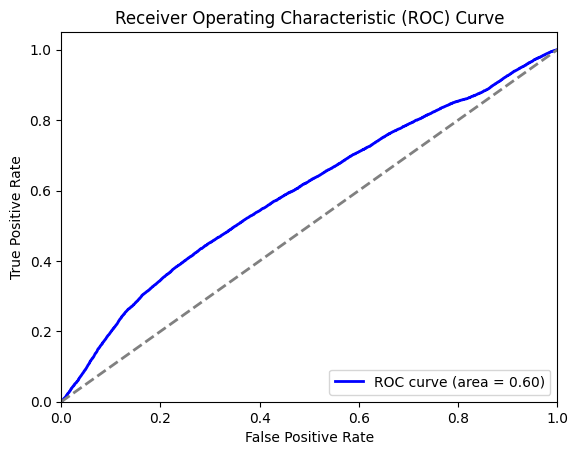

Precision:  0.0
Recall:  0.0
F1-Score:  0.0
AUC:  0.595324594658232
Accuracy:  0.7977629748589136


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
#VII) Fit 3: Random Forest

#1) Fit the training data for Decision Tree
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(x, y_numeric)

#2) 10-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(random_forest, x, y_numeric, cv=cv)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

#3) Plot the ROC Curve
y_prob = logistic_regression.predict_proba(x)[:, 1]
fpr, tpr, _ = roc_curve(y_numeric, y_prob)
auc = roc_auc_score(y_numeric, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#4) Print out the performance metrics
y_pred = logistic_regression.predict(x)
print("Precision: ", precision_score(y_numeric, y_pred))
print("Recall: ", recall_score(y_numeric, y_pred))
print("F1-Score: ", f1_score(y_numeric, y_pred))
print("AUC: ", roc_auc_score(y_numeric, y_prob))
print("Accuracy: ", accuracy_score(y_numeric, y_pred))

Q3: Suppose the distribution of length of stay of patients in a hospital is given by the graph below. You are given the task to predict the length of stay.
How would you change the problem from a regression problem to a classification problem?

A: To change the problem from a regression to a classification means that we are predicting a category of data as opposed to a numeric value of data
in the dataset.

In this case, we would have categories for our prediction (Ex: Short, Medium, Long). If the length of stay proves to be less than a certain number of
days (Ex: 5), then we predict that the length of the stay is "Short". If the length of stay proves to be between 7-14 days, then we predict that it is
"Medium". Finally, if it is greater than 14 days, then the classification would be "Long".